## My first pytorch model
* This is just an introduction of creating a pytorch model and refresh the basics.
* We will create a ML classifier to detect playing cards
* This is the dataset: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm
import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys

### Pytorch Dataset 


In [2]:
class PlayingCardDataset(Dataset):
    def __init__(self,data_dir,transform = None):
        # Image folder helps take the sub folder name in dir and assumes as the image label and creates it automatically
        self.data = ImageFolder(data_dir,transform=transform)

        pass
    # How many examples does the dataset contain
    def __len__(self):
        return len(self.data)
    # Get the particular instance of the dataset
    def __getitem__(self, index):
        return self.data[index]
    # Get the name of the classes in the dataset
    def classes(self):
        return self.data.classes

In [3]:
data_dir='Dataset/playing_cards/train'
dataset = PlayingCardDataset(data_dir)

In [4]:
## Get a dictionary associating target values with folder names
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
# print(target_to_class)

In [5]:
# We want the image to be in same size.
transform = transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])
data_dir='Dataset/playing_cards/train'
dataset = PlayingCardDataset(data_dir,transform=transform)

In [6]:
# We are going to create the dataset for a pytorch model. We are going to create a batch size and a shuffle
# Shuffling is done in training data only.
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)
for images, labels in dataloader:
    break
print(images.shape,labels.shape)

torch.Size([32, 3, 128, 128]) torch.Size([32])


### Pytorch model
 * we are going to use some pre-defined model using tim.


In [7]:
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes = 53):
        # Where we define all the parts of the model
        # This below super is added because it needs to enhirt from the parent class.
        super(SimpleCardClassifier, self).__init__()
        # We are using the efficient b0 architecture. bo is the size of the model
        # Pretrained = true, is the weights have already been tune based on imagenet dataset.
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        # The base model has an additional layer, which we want to remove. The below code helps you do that.

        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        # The output of the model feature size is 1280
        enet_out_size = 1280
        self.classifier = nn.Sequential(nn.Flatten(),nn.Linear(enet_out_size, num_classes))
    def forward(self,x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [8]:
model = SimpleCardClassifier()
# The output is batchsize x value
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

### Training Loop

In [9]:
# First thing is to determine the loss function and optimizer
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion(example_out, labels)
# print(example_out.shape, labels.shape)


In [10]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = 'Dataset/playing_cards/train'
valid_folder = 'Dataset/playing_cards/valid'
test_folder = 'Dataset/playing_cards/test'

train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
# Simple training loop
from tqdm.notebook import tqdm
#Runs through the whole data set 
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleCardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    # Training with the data
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)
        # Gradients in PyTorch accumulate by default, so failing to zero them can lead to incorrect updates.
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Computes gradients of the loss with respect to model parameters (weights and biases).
        loss.backward() # Backpropagation
        # Updates the model parameters using the optimizer (e.g., Adam, SGD).
        optimizer.step() # Update model weights
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
         
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.5332621649329834, Validation loss: 0.5029257828334592


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5369643691892013, Validation loss: 0.2680810885609321


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.3535774253613676, Validation loss: 0.19869888368642555


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.24754214604216132, Validation loss: 0.17842786761949647


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.16756717229002044, Validation loss: 0.19116973072852728


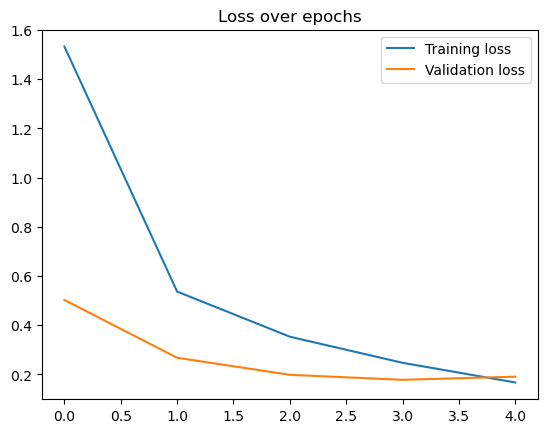

In [13]:
# Visualization of the loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

### Evaluation of results
We are going to take random 10 examples from the test images to test with the existing model.


In [14]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names(), probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

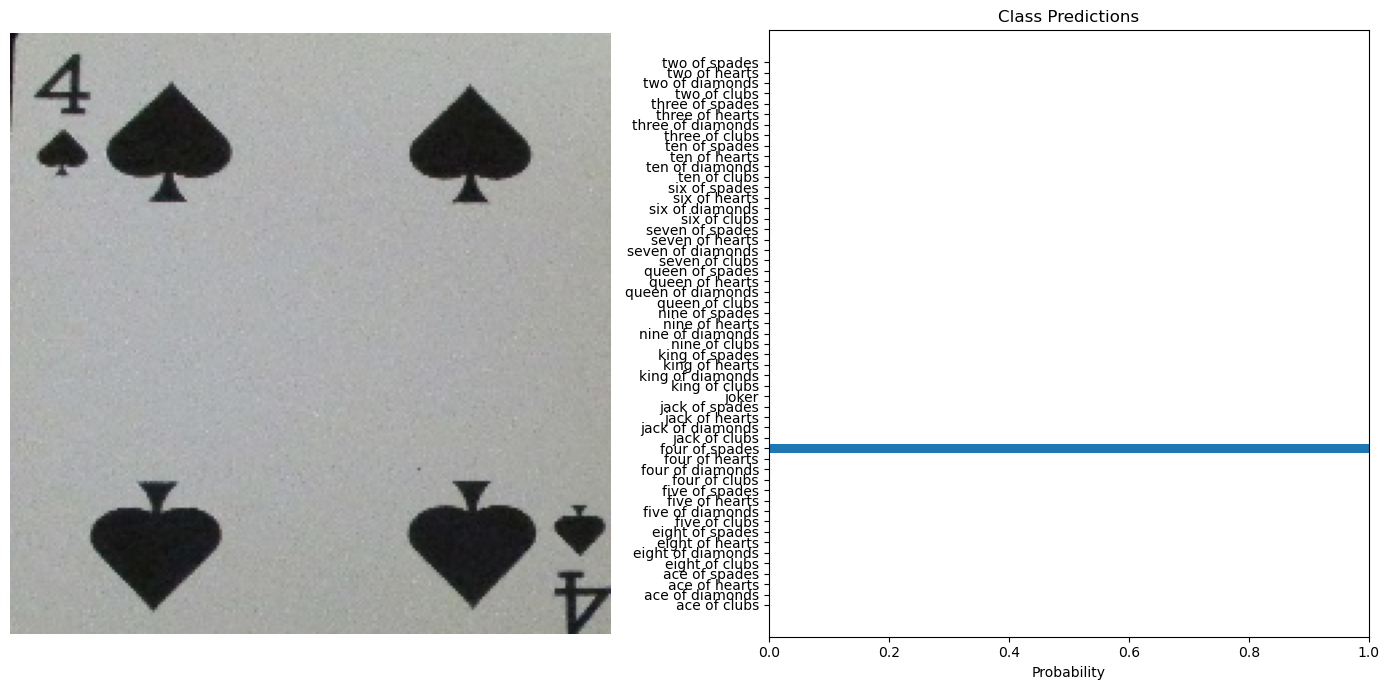

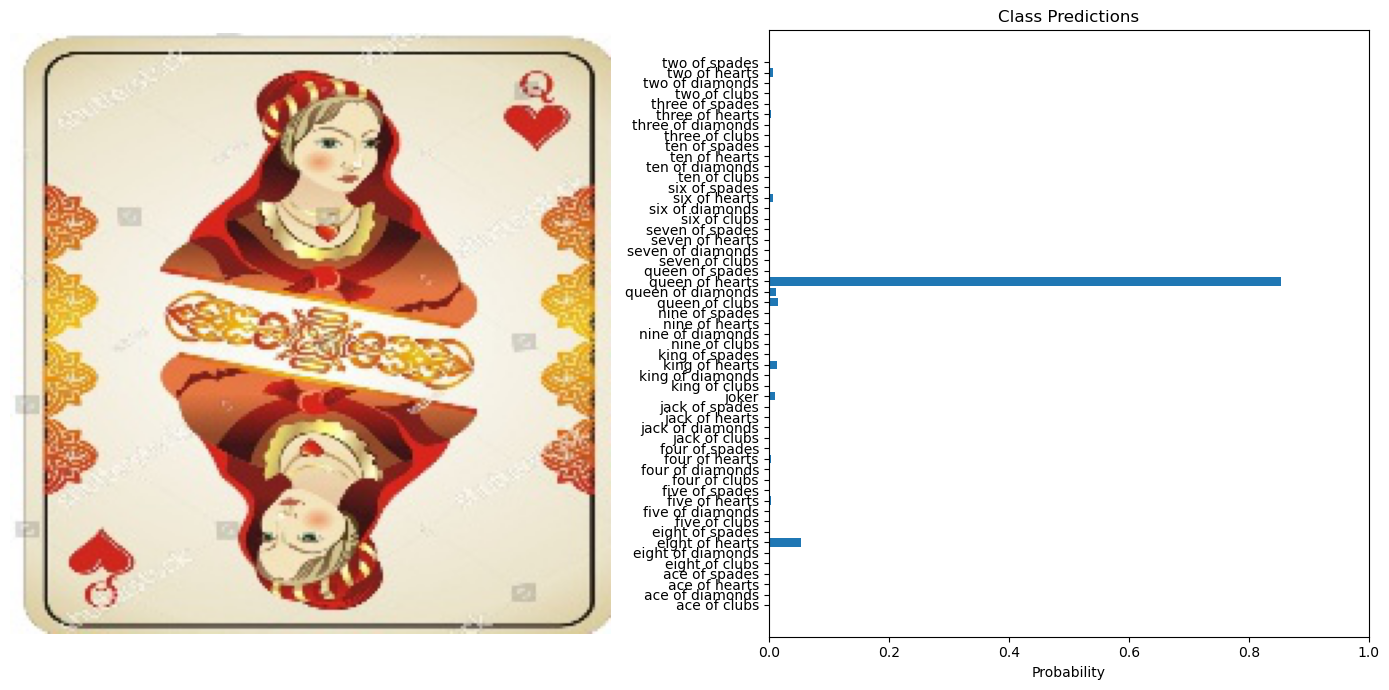

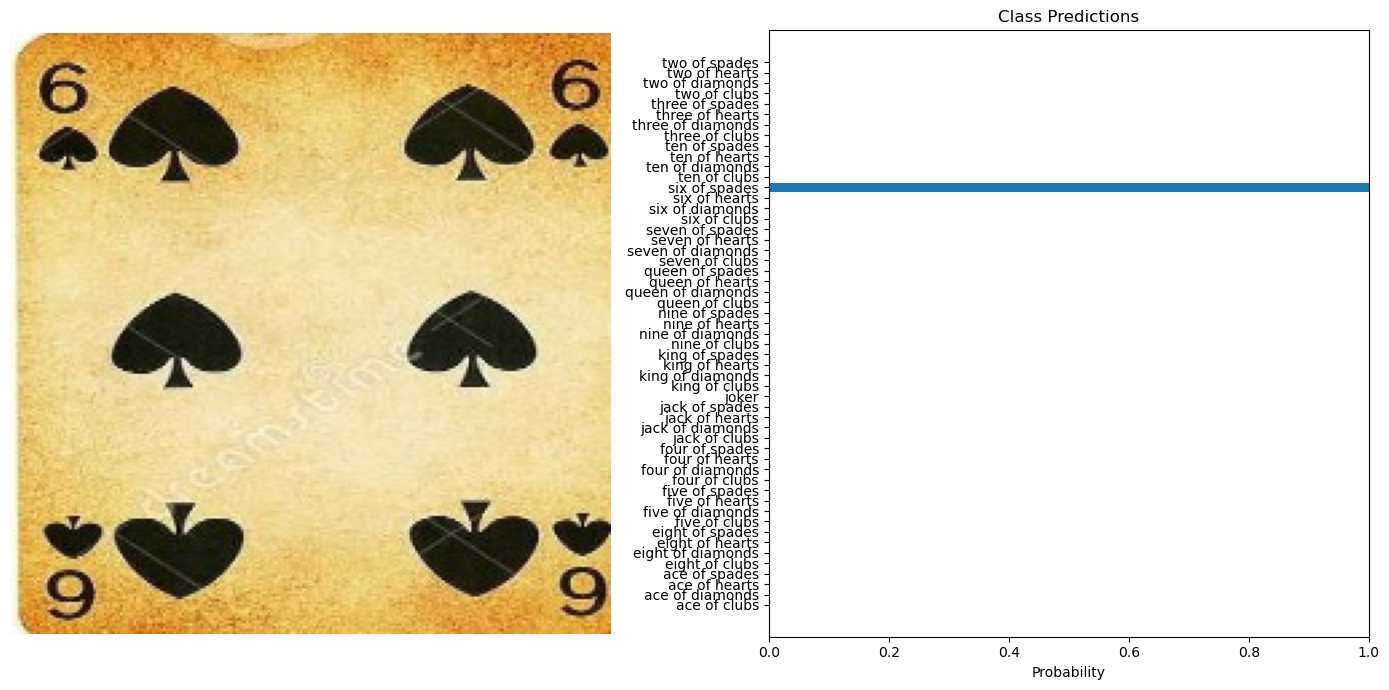

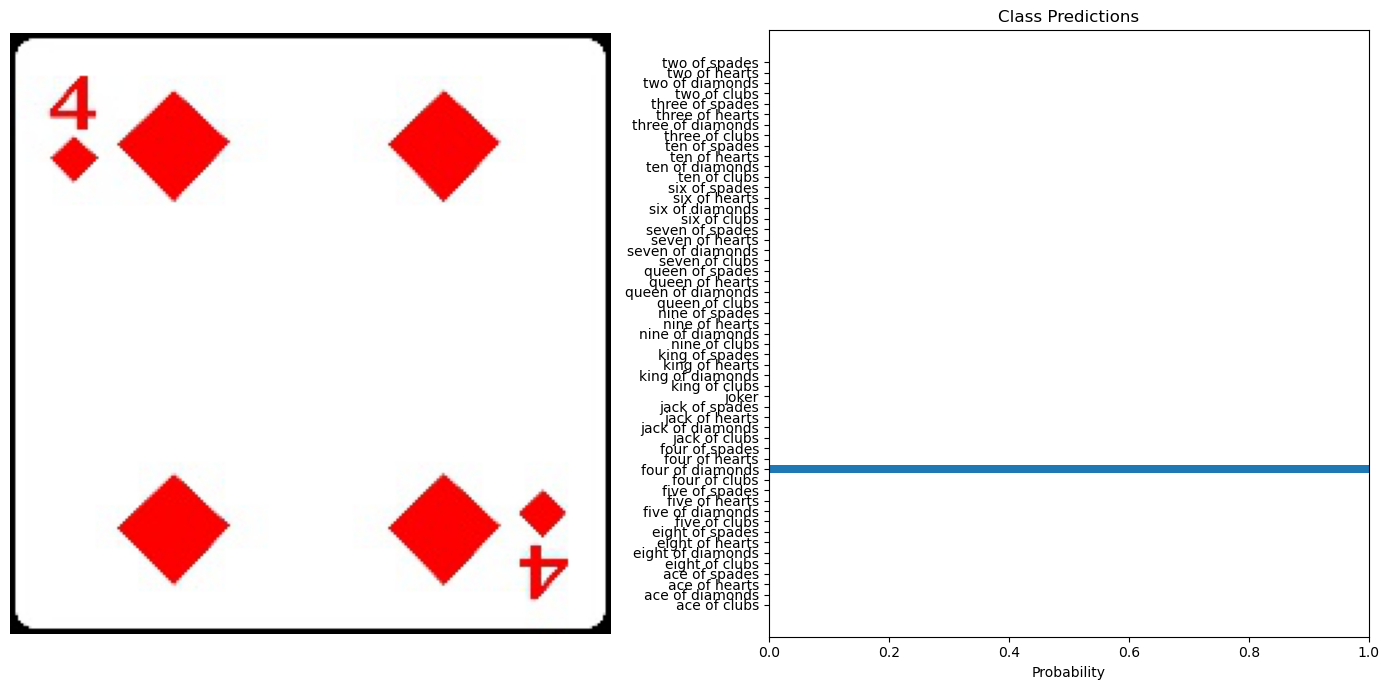

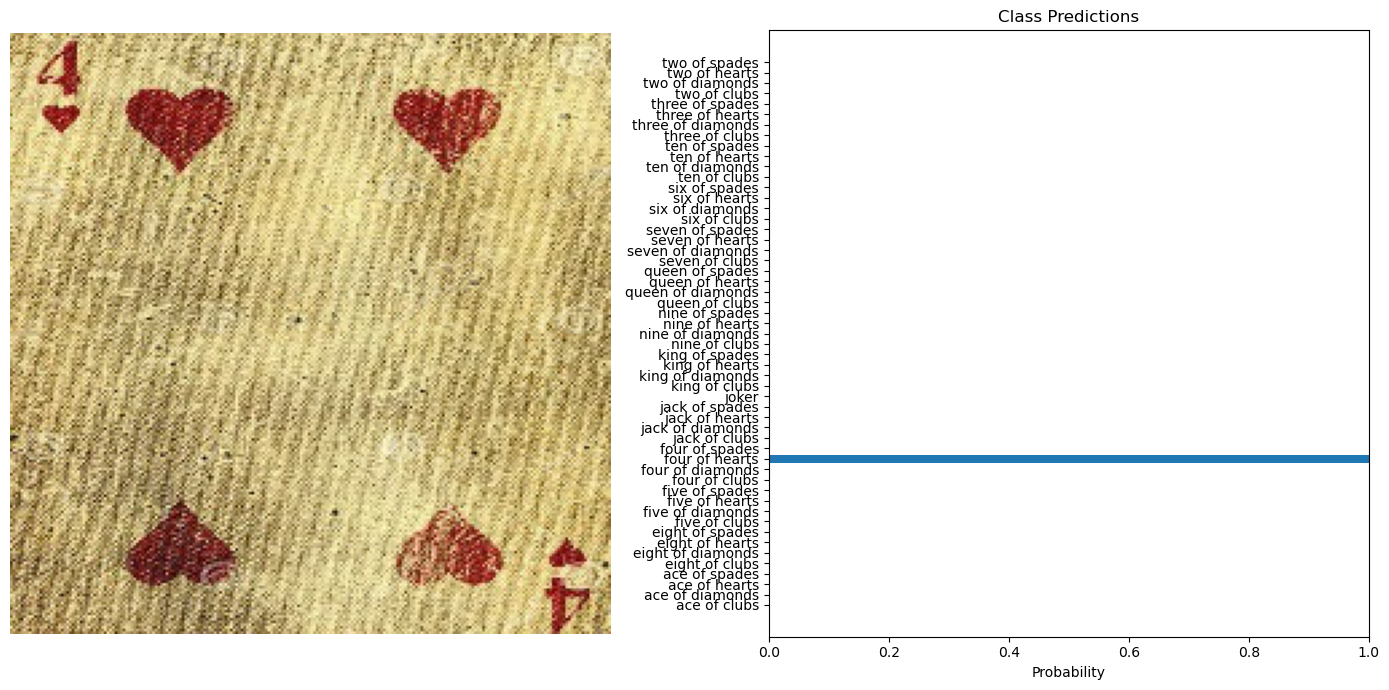

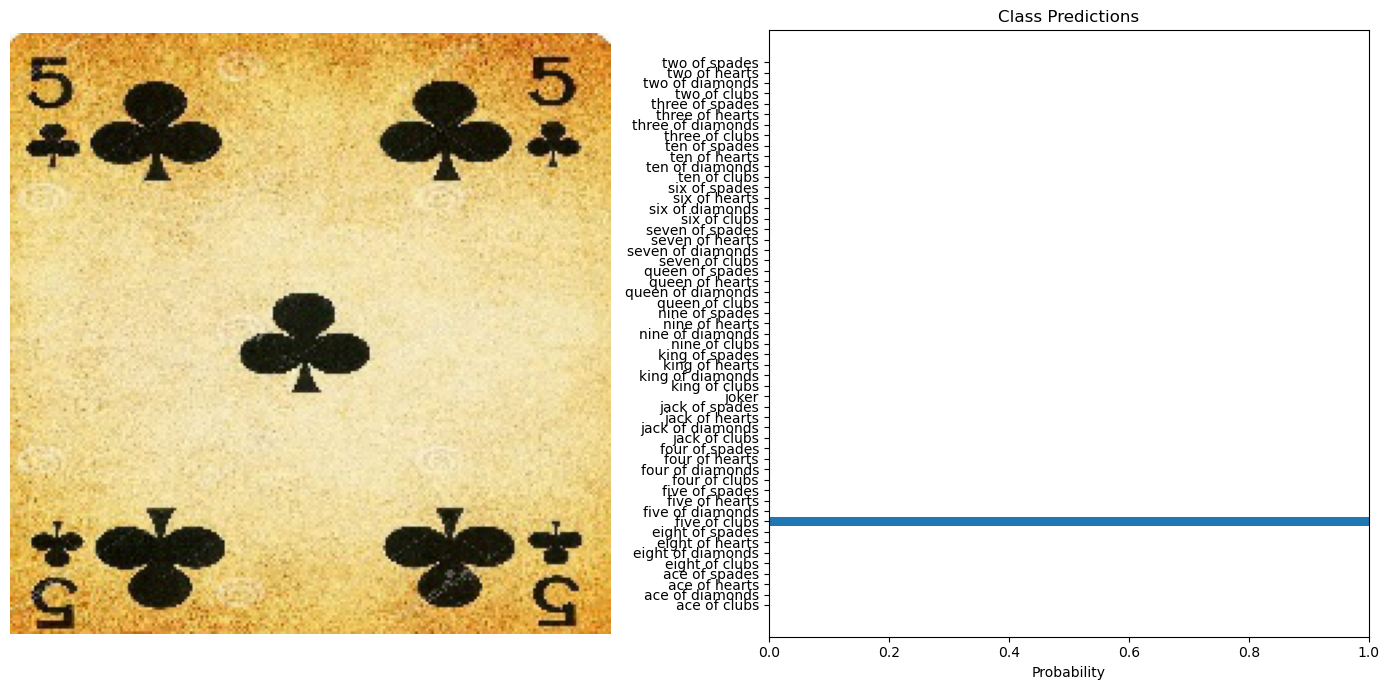

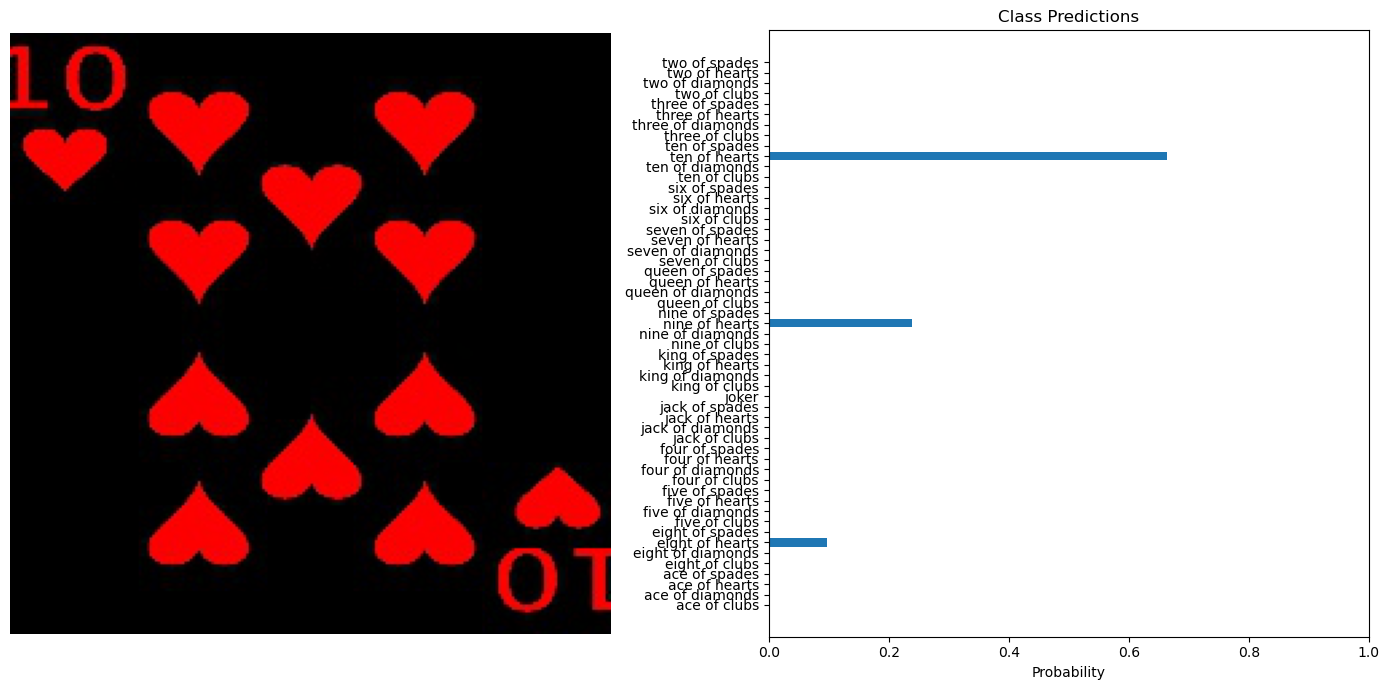

In [15]:
from glob import glob
test_images = glob('Dataset/playing_cards/test/*/*')
test_examples = np.random.choice(test_images, 10)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, device)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

In [25]:
for images, labels in tqdm(train_loader, desc='Training loop'):
    print(images.size())
    print(labels.size())

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([32, 3, 128, 128])
torch.Size([32])
torch.Size([3

KeyboardInterrupt: 